In [36]:
from matplotlib import pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import sys
sys.path.append('../utils')
from helpers import real_gdp_df

plt.style.use('Solarize_Light2')

- **Load GDP data**

In [37]:
GDP_df = real_gdp_df()

# **PPILFE**

- **Load PPILFE data**

In [38]:
PPILFE_df = pd.read_csv('data/PPILFE.csv')

PPILFE_df['DATE'] = pd.to_datetime(PPILFE_df['DATE'])
PPILFE_df.set_index('DATE', inplace=True)

PPILFE_df['^ %'] = PPILFE_df['PPILFE'].pct_change()

PPILFE_df.tail()

,PPILFE,^ %
DATE,,
2015-08-01,193.0,-0.000518
2015-09-01,193.2,0.001036
2015-10-01,192.7,-0.002588
2015-11-01,192.9,0.001038
2015-12-01,193.4,0.002592


- **Average change**

In [39]:
print(f"Average change is {PPILFE_df['^ %'].mean() * 100}%")

Average change is 0.2710824517243756%


- **Overview on change**

In [40]:
positive_filter = PPILFE_df['^ %'] > 0
negative_filter = PPILFE_df['^ %'] < 0
zero_filter = PPILFE_df['^ %'] == 0

# count
total_items = len(PPILFE_df)

# average change
avg_change = [
    PPILFE_df[positive_filter]['^ %'].mean(),
    PPILFE_df[negative_filter]['^ %'].mean(),
    0,
    ""
]

# frequency
frequency = [
    PPILFE_df[positive_filter]['^ %'].count(),
    PPILFE_df[negative_filter]['^ %'].count(),
    PPILFE_df[zero_filter]['^ %'].count()
]
frequency.append(frequency[0]/frequency[1])

# frequency pct
frequency_pct = [100 * frequency[i]/total_items for i in range(3)]
frequency_pct.append("")

# Prob adj
prob_adj = [frequency_pct[i] * avg_change[i] for i in range(3)]
prob_adj.append("")

pd.DataFrame({
    "%": [x * 100 for x in avg_change],
    "Frequency": frequency,
    "Frequency %": frequency_pct,
    "Prob Adjust % Change": prob_adj,
}, index=["Av Pos", "Av Neg", "Zero", "Ratio P/N"])

,%,Frequency,Frequency %,Prob Adjust % Change
Av Pos,0.358227,409.000000,81.150794,0.290704
Av Neg,-0.207353,49.000000,9.722222,-0.020159
Zero,0,45.000000,8.928571,0.0
Ratio P/N,,8.346939,,


- **Stats**

In [41]:
from scipy.stats import describe

# Display the results

stats = describe(PPILFE_df['^ %'].dropna().tolist())
pd.DataFrame(
    {
        'value': [
            str(stats.nobs),
            stats.minmax[0] * 100,
            stats.minmax[1] * 100,
            stats.mean * 100,
            PPILFE_df['^ %'].median() * 100,
            PPILFE_df['^ %'].mode(dropna=True)[0] * 100,
            stats.variance,
            stats.skewness,
            stats.kurtosis
        ]
    },
    index=['nobs', 'Min %', 'Max %', 'Mean %', "Median %", "Mode %", 'Variance', 'Skewness', 'Kurtosis'],
)

,value
nobs,503
Min %,-1.24451
Max %,2.152642
Mean %,0.271082
Median %,0.212766
Mode %,0.0
Variance,0.000012
Skewness,1.37522
Kurtosis,5.680209


- **Data preview**

In [42]:
# Define bins
bins = [0.005 * i for i in range(-2, 5)]
bins.append(stats.minmax[1])
bins.insert(0, stats.minmax[0])
bin_labels = [f"{round(bins[i] * 100, 2)}% to {round(bins[i+1] * 100, 2)}%" for i in range(len(bins) - 1)]
bin_labels[0] = f"Less than {bins[1] * 100}%"
bin_labels[-1] = f"Greater than {bins[-2] * 100}%"

# Assign data to bins
binned = pd.cut(PPILFE_df['^ %'], bins=bins, labels=bin_labels, include_lowest=True)

# Calculate frequency, probability, and cumulative probability
frequency = binned.value_counts().sort_index()
probability = 100 * frequency / frequency.sum()
cumulative_probability = probability.cumsum()

occurrence_frequencies = pd.DataFrame({
    'Frequency': frequency.values,
    'Probability %': probability.values,
    'Cumulative Probability %': cumulative_probability.values
}, index=bin_labels)

occurrence_frequencies

,Frequency,Probability %,Cumulative Probability %
Less than -1.0%,1,0.198807,0.198807
-1.0% to -0.5%,5,0.994036,1.192843
-0.5% to 0.0%,88,17.495030,18.687873
0.0% to 0.5%,320,63.618290,82.306163
0.5% to 1.0%,72,14.314115,96.620278
1.0% to 1.5%,11,2.186879,98.807157
1.5% to 2.0%,5,0.994036,99.801193
Greater than 2.0%,1,0.198807,100.000000


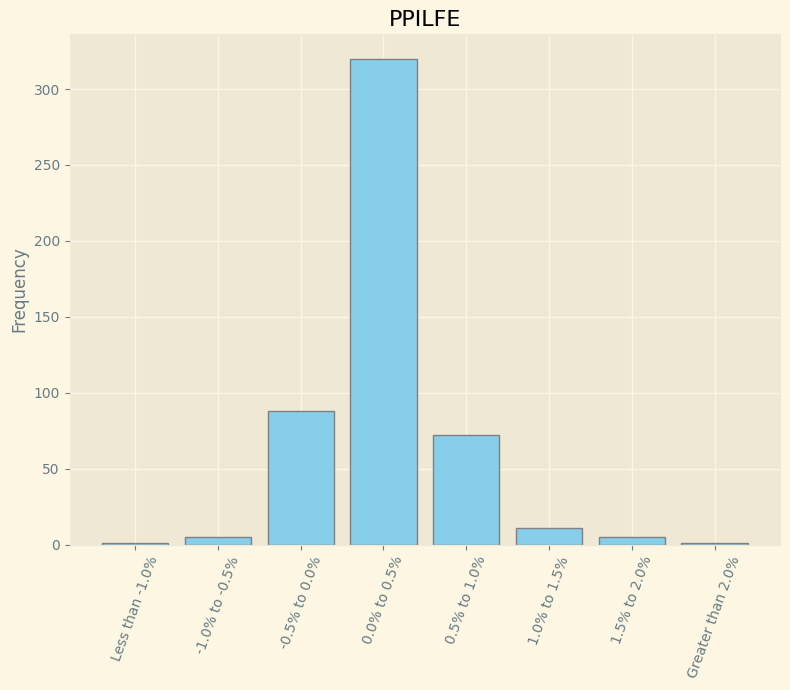

In [43]:
plt.figure(figsize=(8, 7))

plt.bar(occurrence_frequencies.index, occurrence_frequencies['Frequency'], color='skyblue', edgecolor='gray')

# median_age = df['^ %'].median()
# plt.axvline(median_age, color='#fc4f30', label='Change Median')

# Add labels and title
plt.title('PPILFE')
plt.xlabel('')
plt.ylabel('Frequency')
plt.xticks(rotation=70) 
# Show the chart
plt.tight_layout()
plt.show();

- PPILFE pct change

In [48]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=PPILFE_df.index, 
    y=[100 * stats.mean] * (stats.nobs + 1), 
    name='PMI 50 Points',
    line=dict(width=2),
    hoverinfo="skip",
    showlegend=False,
    marker=dict(color='red'),
))

fig.add_trace(go.Bar(
    x=PPILFE_df.index,
    y=PPILFE_df['^ %'] * 100,
    name='PPILFE',
    marker=dict(line=dict(color='rgba(0, 0,250, .9)', width=2)),
    width=0,
))

fig.update_layout(
    title=dict(text='PPILFE pct change'),
    plot_bgcolor='rgb(230, 230,230)',
    width=1400,
    height=700,
    yaxis=dict(title="%", exponentformat="none", showgrid=False),
    barmode="group",
    hovermode="x unified",
    xaxis=dict(showgrid=False),
)

fig.show()

- **PPILFE data plot**

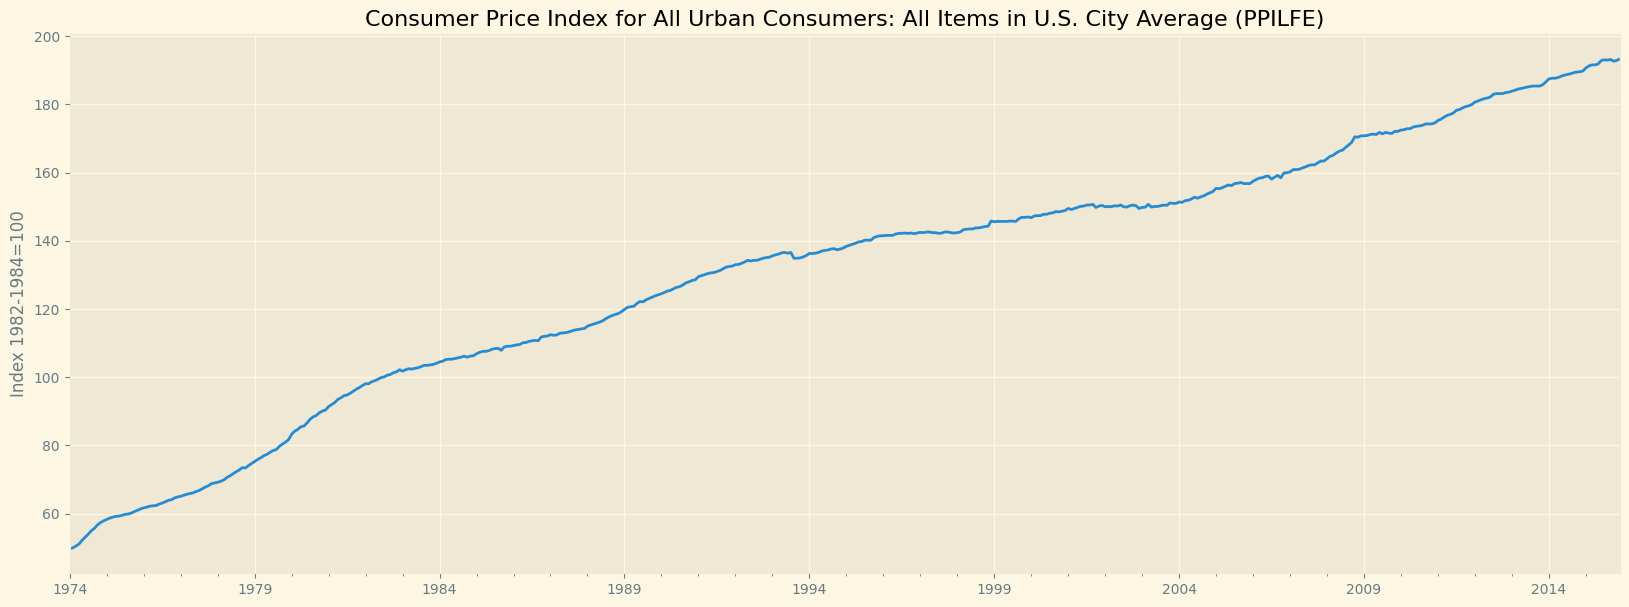

In [45]:
PPILFE_df['PPILFE'].plot(
    figsize=(20, 7),
    xlabel='',
    ylabel='Index 1982-1984=100',
    title='Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (PPILFE)',
);

- **PPILFE vs GDP Growth**

In [46]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=PPILFE_df.index,
    y=PPILFE_df['^ %'] * 100,
    name='PPILFE',
    fill='tonexty',
    fillcolor='rgba(109,215,253, 0.9)',
    line=dict(color='rgba(109,215,253, 0.9)', width=1),
))

fig.add_trace(go.Bar(
    x=GDP_df.index,
    y=GDP_df['GDP'],
    name='GDP',
    marker=dict(color='red'),
    yaxis="y2"  
))

# ------------------------------------------------------------------------
level_a = 0  # Level on left y-axis
level_b = 0  # Matching level on right y-axis

# Define the ranges for each axis
range_left = [(PPILFE_df['^ %'] * 100).min() - .25, (PPILFE_df['^ %'] * 100).max() + .25]  # Min and max for right y-axis (to be adjusted)
range_right = [GDP_df['GDP'].min() - 5, GDP_df['GDP'].max() + 5]  # Min and max for left y-axis

# Calculate scaling factor to align levels
proportion = (level_a - range_left[0]) / (range_left[1] - range_left[0])  # Position of level_a
range_right[1] = range_right[0] + (level_b - range_right[0]) / proportion  # Adjust right range
# ------------------------------------------------------------------------

fig.update_layout(
    title=dict(text='PPILFE vs GDP Growth'),
    plot_bgcolor='rgb(0, 0, 0)',
    width=1400,
    height=700,
    # hovermode="y unified",
    yaxis=dict(title="PPILFE pct change %", exponentformat="none", range=range_left, showgrid=False),
    yaxis2=dict(title="Real GDP change in %", overlaying="y", side="right", range=range_right, showgrid=False),
    barmode="group",
    legend=dict(x=0.5, y=-0.2, orientation="h"),
    xaxis=dict(showgrid=False),
)

fig.show()